In [80]:
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from  sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [81]:
banking = pd.read_csv('../linear_regression_case_study/SRC/banking.csv')
banking.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length
0,8.90,735-739,20000.0,20000.0,36.0
1,12.12,715-719,19200.0,19200.0,36.0
2,21.98,690-694,35000.0,35000.0,60.0
3,9.99,695-699,10000.0,9975.0,36.0
4,11.71,695-699,12000.0,12000.0,36.0


In [82]:
banking.info()
banking.describe(include='all')
banking.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interest_rate               2498 non-null   float64
 1   fico_range                  2498 non-null   object 
 2   amount_requested            2498 non-null   float64
 3   amount_funded_by_investors  2498 non-null   float64
 4   loan_length                 2498 non-null   float64
dtypes: float64(4), object(1)
memory usage: 97.7+ KB


interest_rate                 0
fico_range                    0
amount_requested              0
amount_funded_by_investors    0
loan_length                   0
dtype: int64

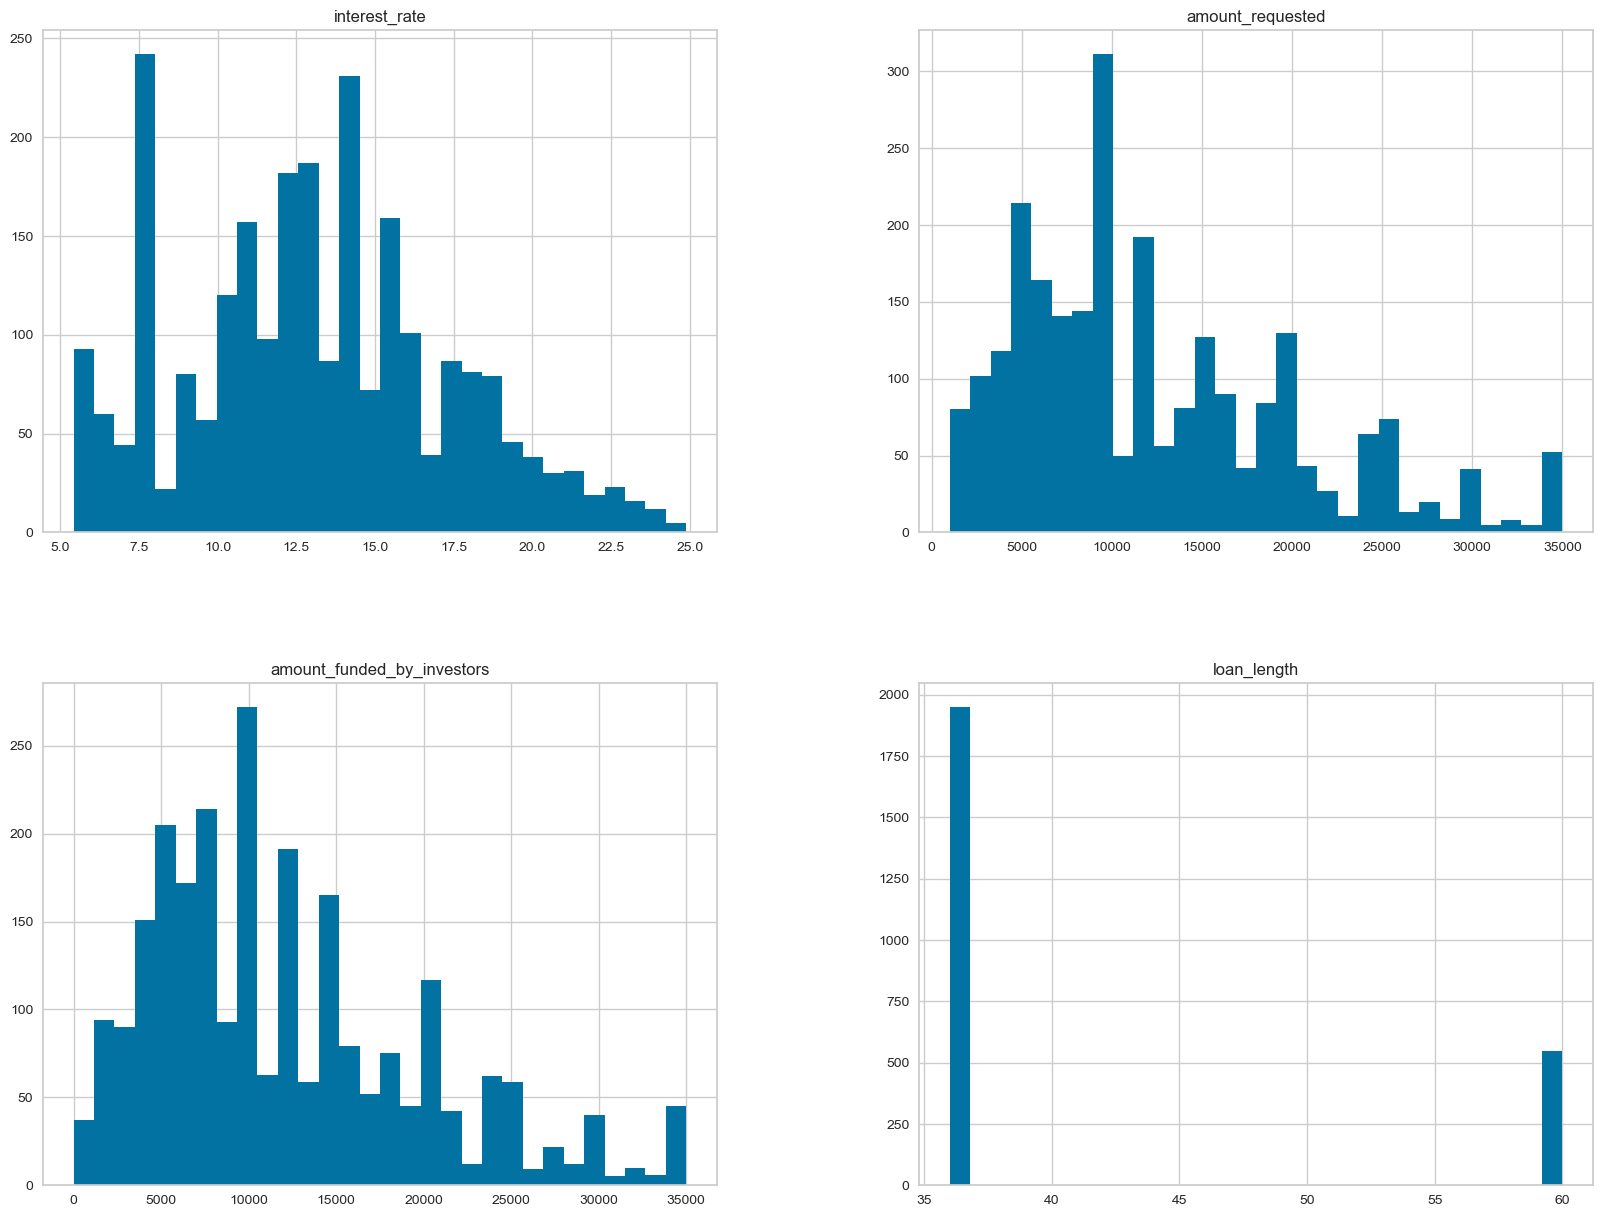

In [83]:
banking.hist(bins=30, figsize=(20,15))
plt.show()

From the histograms, we can observe the following:

- interest_rate: Most of the interest rates are between 10 and 15 (presumably percentage) .
- amount_requested and amount_funded_by_investors: These two are very similar, indicating that most of the requested amounts are funded. The distribution is right-skewed, with most of the loans being less than 20000.
- loan_length: There are two major categories in loan length, around 36 and 60.

<Axes: >

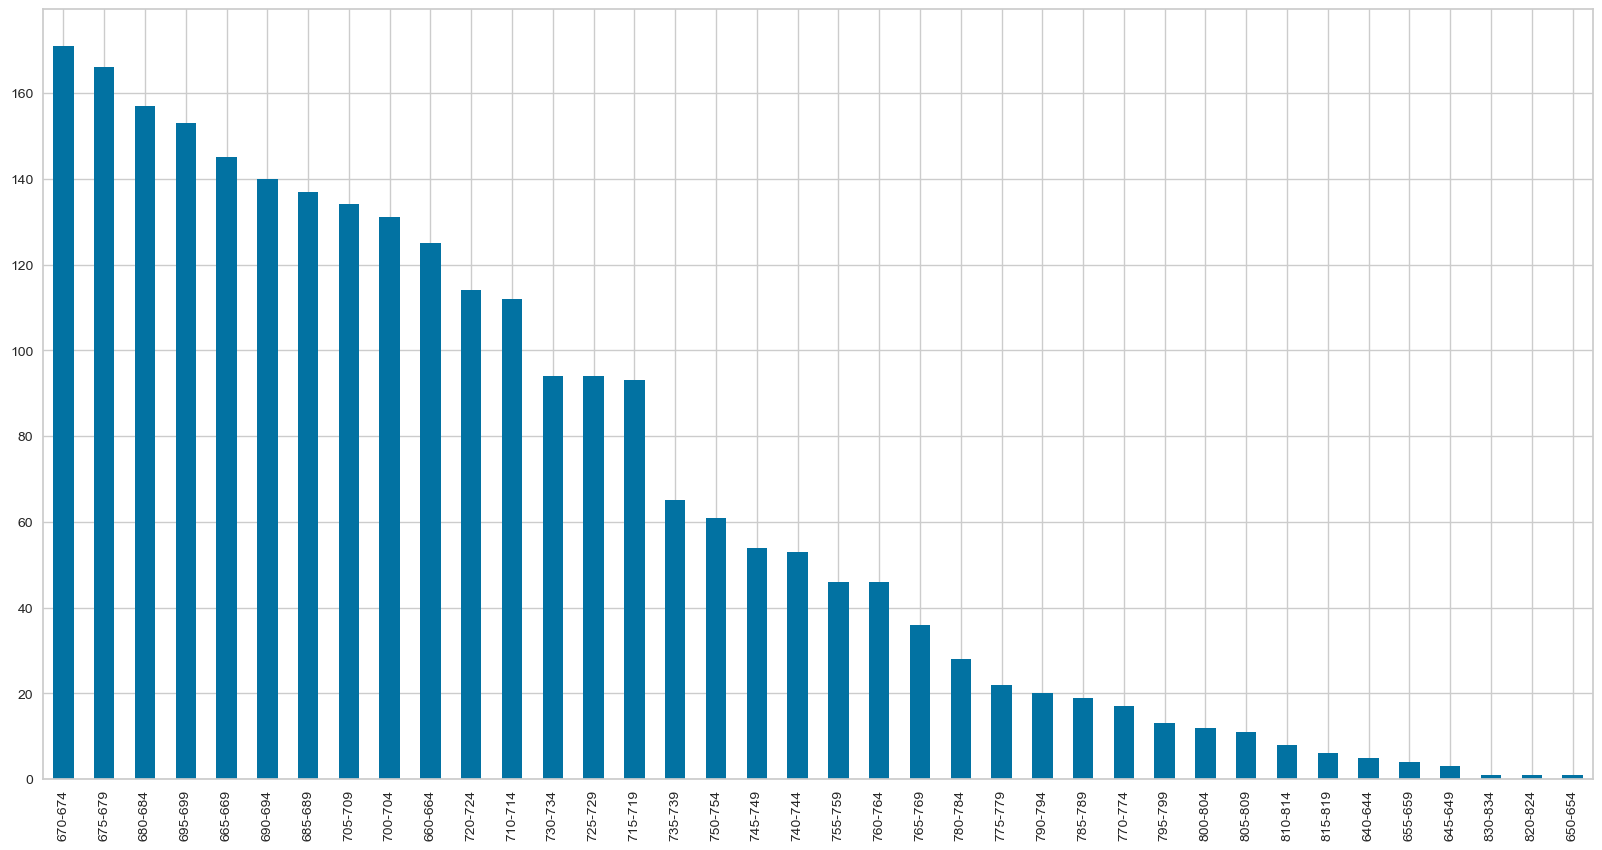

In [84]:
fico_counts = banking['fico_range'].value_counts()
fico_counts.plot(kind='bar', figsize=(20,10))

The fico_range column has many unique values, which makes the bar plot a bit cluttered. However, we can still see that some FICO ranges are more common than others.

C:\Users\austi\AppData\Local\Temp\ipykernel_23920\1209599206.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = banking.corr()


<Axes: >

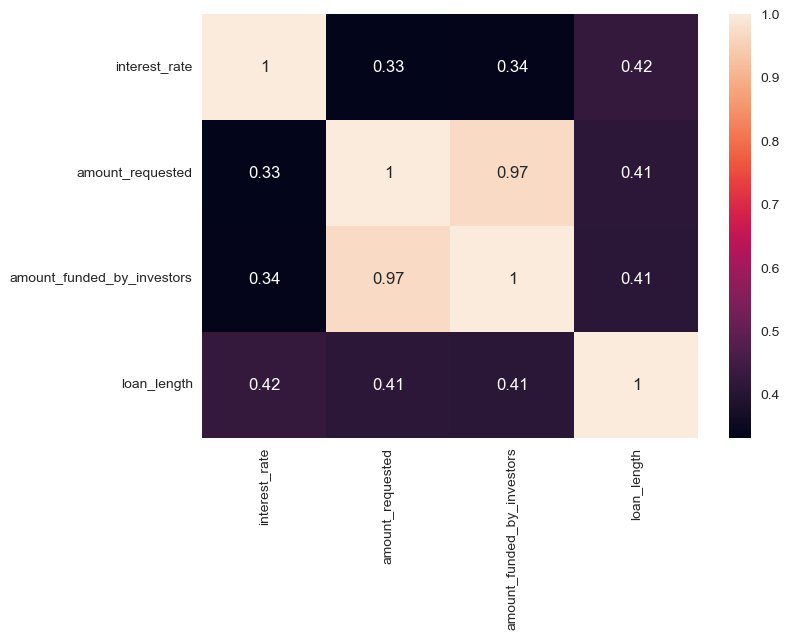

In [85]:
corr_matrix = banking.corr()
sns.heatmap(corr_matrix, annot=True)

For some reason, the fico_range column is not displaying. I need to fix that. 

In [86]:
# Convert fico_range to numerical by taking the average
banking['fico_average'] = banking['fico_range'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1])) / 2)
banking.drop('fico_range', axis=1, inplace=True)
banking.head()

,interest_rate,amount_requested,amount_funded_by_investors,loan_length,fico_average
0,8.90,20000.0,20000.0,36.0,737.0
1,12.12,19200.0,19200.0,36.0,717.0
2,21.98,35000.0,35000.0,60.0,692.0
3,9.99,10000.0,9975.0,36.0,697.0
4,11.71,12000.0,12000.0,36.0,697.0


<Axes: >

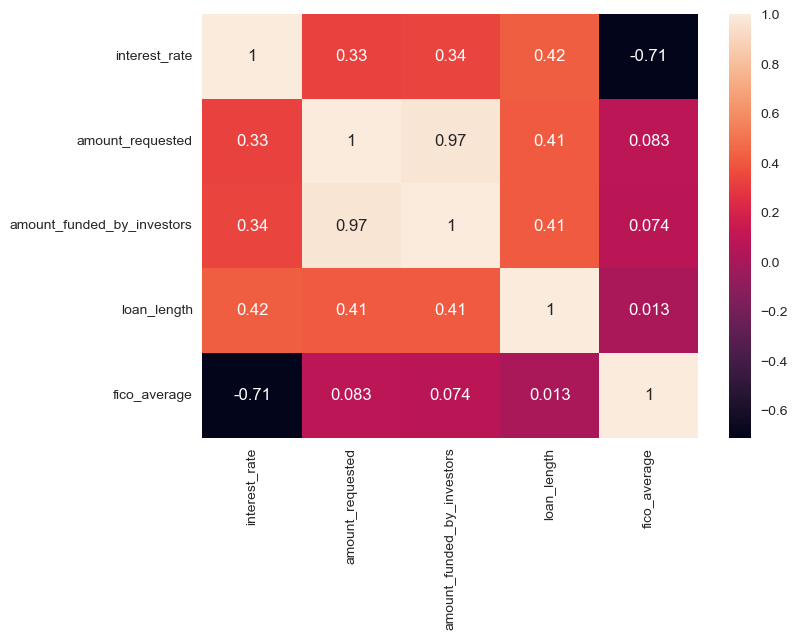

In [87]:
corr_matrix = banking.corr()
sns.heatmap(corr_matrix, annot=True)

From the correlation matrix, we can observe the following:

- interest_rate has a moderate negative correlation with fico_average, indicating that higher FICO scores tend to have lower interest rates.
- interest_rate has a moderate positive correlation with loan_length, indicating that longer loans tend to have higher interest rates.
- amount_requested and amount_funded_by_investors are highly correlated, which is expected as most of the requested amounts are funded.

### Austin's suggested way ahead:
y (target) should be the interest_rate column compared against all of the other columns (features). We should build a linear regression model, first by splitting the data into training and test sets, then by analyzed the effect of the individual cooeficients to detect any issues with the models.  

In [88]:
# Define features and target
features = ['amount_requested', 'amount_funded_by_investors', 'loan_length', 'fico_average']
target = 'interest_rate'
# Split the data into training and test sets
X = banking[features]
y = banking[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

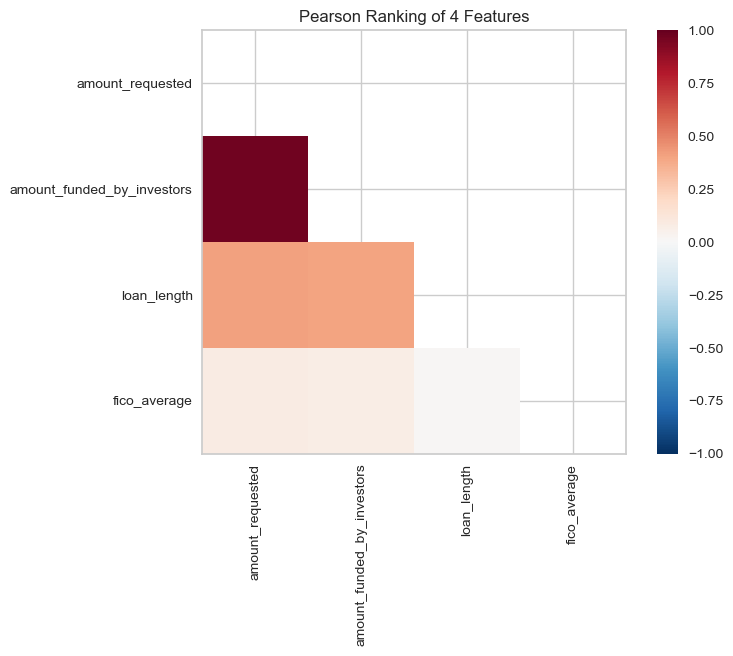

<Axes: title={'center': 'Pearson Ranking of 4 Features'}>

In [89]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X)
visualizer.show()

In [90]:
funded_train = np.asarray(X_train['amount_funded_by_investors'])
requested_train = np.asarray(X_train['amount_requested'])
fico_train = np.asarray(X_train['fico_average'])
loan_ln_train = np.asarray(X_test['loan_length'])
funded_test = np.asarray(X_test['amount_funded_by_investors'])
reqested_test = np.asarray(X_test['amount_requested'])
fico_test = np.asarray(X_test['fico_average'])
loan_ln_test = np.asarray(X_test['loan_length'])

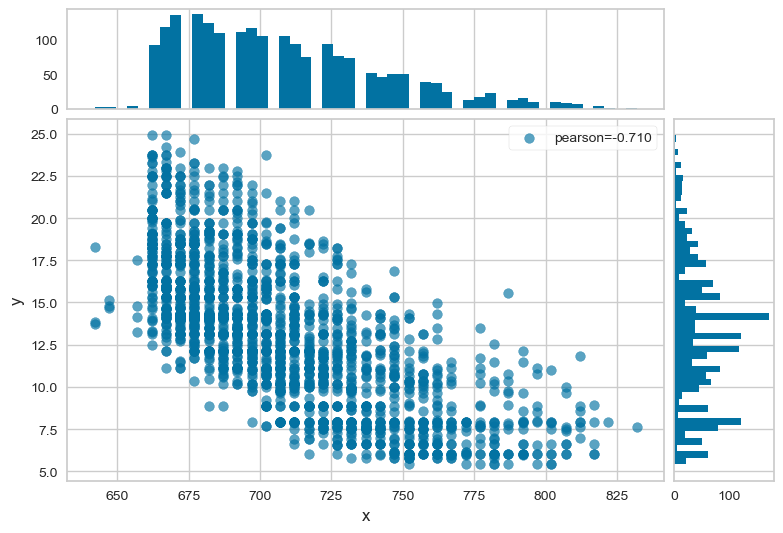

<Axes: xlabel='x', ylabel='y'>

In [91]:
from yellowbrick.features import JointPlotVisualizer

X1 = fico_train
y1 = y_train

visualizer = JointPlotVisualizer()
visualizer.fit_transform(X1, y1)
visualizer.show()

In [92]:
import statsmodels.api as sm
# Add a constant to the features
X_train_const = sm.add_constant(X_train)
# Create an OLS model
model = sm.OLS(y_train, X_train_const)
# Fit the model
results = model.fit()
# Print the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     1497.
Date:                Fri, 28 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:27:53   Log-Likelihood:                -4309.2
No. Observations:                1998   AIC:                             8628.
Df Residuals:                    1993   BIC:                             8656.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

The p-values for all the coefficients are less than 0.05, indicating that all the variables are statistically significant.

The condition number is large, indicating that there might be strong multicollinearity or other numerical problems. This means that some of the features might be highly correlated with each other, which can affect the stability of the model. We might need to address this issue by removing some of the correlated features or using regularization techniques.

In [93]:
# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate the mean squared error and the r-squared value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Print the coefficients, the mean squared error and the r-squared value
print('Coefficients: \n', model.coef_)
print('Mean squared error: %.2f' % mse)
print('Coefficient of determination: %.2f' % r2)

Coefficients: 
 [ 7.84601794e-05  6.19916455e-05  1.38224988e-01 -8.82105474e-02]
Mean squared error: 4.64
Coefficient of determination: 0.73


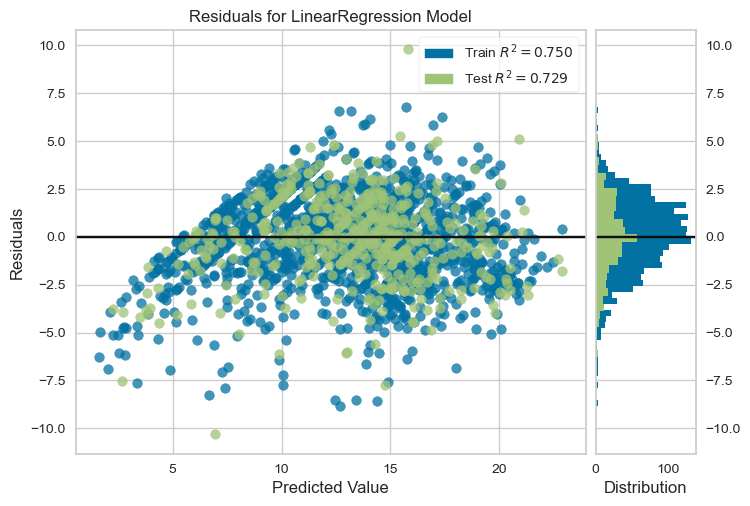

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [94]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

Here are the results of the linear regression model:

Coefficients:

- amount_requested: 7.85e-05
- amount_funded_by_investors: 6.20e-05
- loan_length: 0.138
- fico_average: -0.088
- Mean squared error: 4.64

Coefficient of determination (R-squared): 0.73

The coefficients indicate how much the dependent variable (interest_rate) is expected to increase when the corresponding independent variable increases by one, holding all other independent variables constant. For example, for each additional unit of loan_length, the interest_rate increases by 0.138, assuming all other factors remain constant.

The negative coefficient for fico_average suggests that as the FICO score increases, the interest rate decreases, which aligns with our understanding that better credit scores often lead to lower interest rates.

The mean squared error (MSE) is a measure of how well the model predicts the actual values. In this case, the MSE is 4.64.

The coefficient of determination, or R-squared, is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. In this case, the R-squared is 0.73, indicating that approximately 73% of the variation in interest_rate can be explained by our model.

## Potential Hypotheses we can extrapolate from this initial analysis

1. Null Hypothesis ($H_0$): There is no relationship between the FICO score and the interest rate.

Alternate Hypothesis ($H_1$): There is a relationship between the FICO score and the interest rate. 

(Our analysis suggests that higher FICO scores are associated with lower interest rates.)

2. Null Hypothesis ($H_0$): All features are equally important in predicting the interest rate.

Alternate Hypothesis ($H_1$): Some features are more important than others in predicting the interest rate. 

(This hypothesis tests the effect of regularization, which can help us identify the most important features.)

3. Null Hypothesis ($H_0$): The relationship between the amount requested and the interest rate is linear.

Alternate Hypothesis ($H_1$): The relationship between the amount requested and the interest rate is not linear. 

(This hypothesis tests whether a transformation of the amount requested variable might improve the model.)

# Moving forward with:

Null Hypothesis ($H_0$): All features are equally important in predicting the interest rate.
y = x1 = x2 = x3

Alternate Hypothesis ($H_1$): Some features are more important than others in predicting the interest rate. 

(This hypothesis tests the effect of regularization, which can help us identify the most important features.)


Steps to analyze this hypothesis:
1. Scale appropriate data
2. Run Ridge Regression with MSE and cross value scores
3. Run Lasso Regression with MSE and cross value scores
4. Compare the two to figure out which model is best
5. Determine predictive frame
6. Make predictions


In [95]:
banking.head()

,interest_rate,amount_requested,amount_funded_by_investors,loan_length,fico_average
0,8.90,20000.0,20000.0,36.0,737.0
1,12.12,19200.0,19200.0,36.0,717.0
2,21.98,35000.0,35000.0,60.0,692.0
3,9.99,10000.0,9975.0,36.0,697.0
4,11.71,12000.0,12000.0,36.0,697.0


In [96]:
scaler = StandardScaler()
features = banking[banking.columns.difference(['interest_rate'])]
target = banking['interest_rate']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [97]:
# Define the alphas
alphas = np.logspace(-4, 4, 200)

# Initialize the RidgeCV model
ridge = RidgeCV(alphas=alphas, cv=5)

# Fit the model
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-04, 1.09698580e-04, 1.20337784e-04, 1.32008840e-04,
       1.44811823e-04, 1.58856513e-04, 1.74263339e-04, 1.91164408e-04,
       2.09704640e-04, 2.30043012e-04, 2.52353917e-04, 2.76828663e-04,
       3.03677112e-04, 3.33129479e-04, 3.65438307e-04, 4.00880633e-04,
       4.39760361e-04, 4.82410870e-04, 5.29197874e-04, 5.80522552e-04,
       6.36824994e-04, 6.98587975e-0...
       1.18953407e+03, 1.30490198e+03, 1.43145894e+03, 1.57029012e+03,
       1.72258597e+03, 1.88965234e+03, 2.07292178e+03, 2.27396575e+03,
       2.49450814e+03, 2.73644000e+03, 3.00183581e+03, 3.29297126e+03,
       3.61234270e+03, 3.96268864e+03, 4.34701316e+03, 4.76861170e+03,
       5.23109931e+03, 5.73844165e+03, 6.29498899e+03, 6.90551352e+03,
       7.57525026e+03, 8.30994195e+03, 9.11588830e+03, 1.00000000e+04]),
        cv=5)

In [101]:
def cv(X, y, base_estimator, n_folds, random_seed=154):
    """Estimate the in- and out-of-sample error of a model using cross
    validation.

    Parameters
    ----------

    X: np.array
      Matrix of predictors.

    y: np.array
      Target array.

    base_estimator: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.

    n_folds: int
      The number of folds in the cross validation.

    random_seed: int
      A seed for the random number generator, for repeatability.

    Returns
    -------

    train_cv_errors, test_cv_errors: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
    test_cv_errors, train_cv_errors = np.empty(n_folds), np.empty(n_folds)
    for idx, (train, test) in enumerate(kf.split(X)):
        # Split into train and test
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
        # Fit estimator
        base_estimator.fit(X_train, y_train)
        # Make predictions
        y_train_pred = base_estimator.predict(X_train)
        y_test_pred = base_estimator.predict(X_test)
        # Calculate MSE
        train_cv_errors[idx] = mean_squared_error(y_train, y_train_pred)
        test_cv_errors[idx] = mean_squared_error(y_test, y_test_pred)
    return train_cv_errors, test_cv_errors

In [102]:
def train_at_various_alphas(X, y, model, alphas, n_folds=10, **kwargs):
    """Train a regularized regression model using cross validation at various
    values of alpha.

    Parameters
    ----------

    X: np.array
      Matrix of predictors.

    y: np.array
      Target array.

    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are `Ridge` and `Lasso`.

    alphas: numpy array
      An array of regularization parameters.

    n_folds: int
      Number of cross validation folds.

    Returns
    -------

    cv_errors_train, cv_errors_test: tuple of DataFrame
      DataFrames containing the training and testing errors for each value of
      alpha and each cross validation fold.  Each row represents a CV fold, and
      each column a value of alpha.
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                    columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        model.alpha = alpha
        train_errors, test_errors = cv(X, y, model, n_folds)
        cv_errors_train.loc[:, alpha] = train_errors
        cv_errors_test.loc[:, alpha] = test_errors
    return cv_errors_train, cv_errors_test

In [114]:
# Call the function
ridge_cv_errors_train, ridge_cv_errors_test = train_at_various_alphas(X_train, y_train, Ridge(), alphas)

# Calculate the mean and standard deviation of the train and test errors for each alpha
ridge_mean_cv_errors_train = ridge_cv_errors_train.mean()
ridge_mean_cv_errors_test = ridge_cv_errors_test.mean()
ridge_std_cv_errors_train = ridge_cv_errors_train.std()
ridge_std_cv_errors_test = ridge_cv_errors_test.std()

# Create a DataFrame for easy plotting
ridge_cv_errors = pd.DataFrame({'mean_train': ridge_mean_cv_errors_train,
                                'mean_test': ridge_mean_cv_errors_test,
                                'std_train': ridge_std_cv_errors_train,
                                'std_test': ridge_std_cv_errors_test})

In [115]:
# Find the optimal alpha
ridge_optimal_alpha = ridge_cv_errors['mean_test'].idxmin()
ridge_optimal_alpha

357.07859649004627

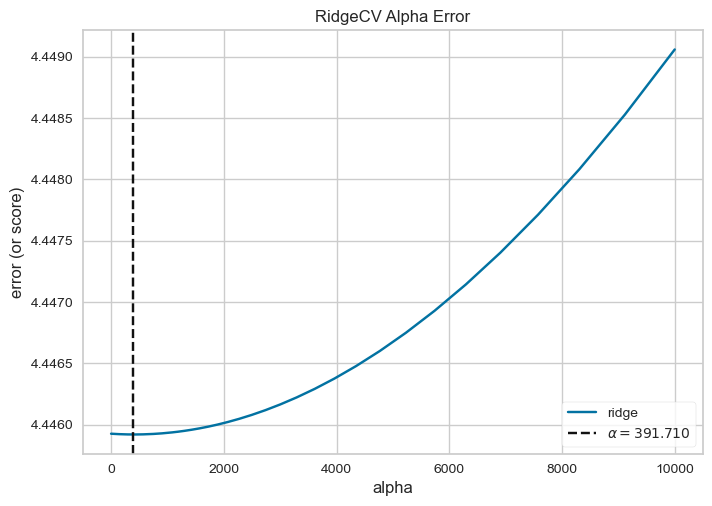

<Axes: title={'center': 'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [112]:
from yellowbrick.regressor import AlphaSelection

visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X, y)
visualizer.show()

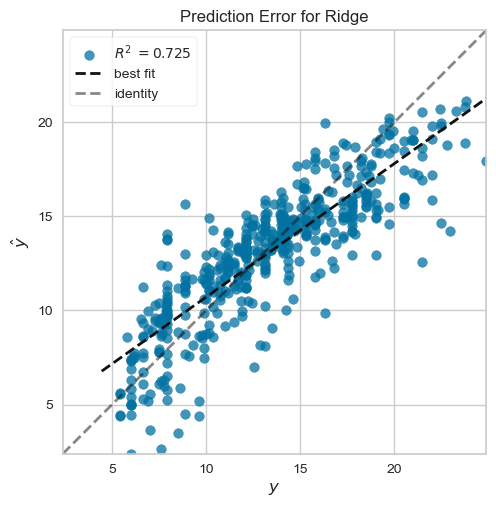

<Axes: title={'center': 'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [116]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(Ridge(alpha=391.710))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [117]:
# Initialize a Ridge object
ridge = Ridge()

# Initialize an empty DataFrame to store the coefficients
coefs = pd.DataFrame(index=alphas, columns=X_train.columns)

In [119]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

c:\Users\austi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=12.
  warnings.warn(


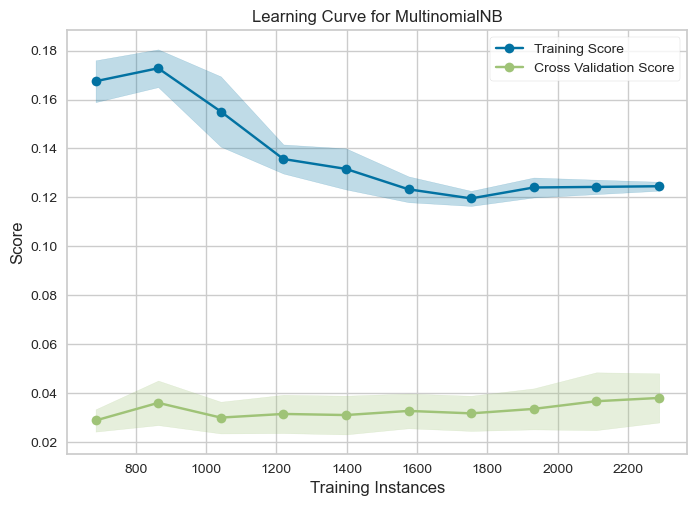

<Axes: title={'center': 'Learning Curve for MultinomialNB'}, xlabel='Training Instances', ylabel='Score'>

In [120]:
# Encode the categorical data
X = OneHotEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [121]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances